# 1. 패키지 임포트 및 설정

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('retina')
%matplotlib inline

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

mpl.rc('font', family='binggrae')
mpl.rc('axes', unicode_minus=True)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 10000

# 2. 데이터 로드
- df_oxi : Oxidation csv table
-

## Oxidation Data

In [2]:
df_oxi = pd.read_csv('../data/project01/Oxid_000.csv')
df_oxi.head(3)

,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,No_Die,Lot_Num,Wafer_Num,Datetime
0,1,Oxidation,dry,1138.979159,O2,32.80,0.200,62,699.443,NOLSM111,1,1,17-02-2019 PM 9:04:30
1,1,Oxidation,dry,1218.184551,O2,31.86,0.194,137,696.792,NOLSM212,1,2,17-02-2019 PM 9:04:30
2,1,Oxidation,dry,1062.467808,O2,39.51,0.217,128,705.471,NOLSM313,1,3,17-02-2019 PM 9:04:30


### 결측치 파악 

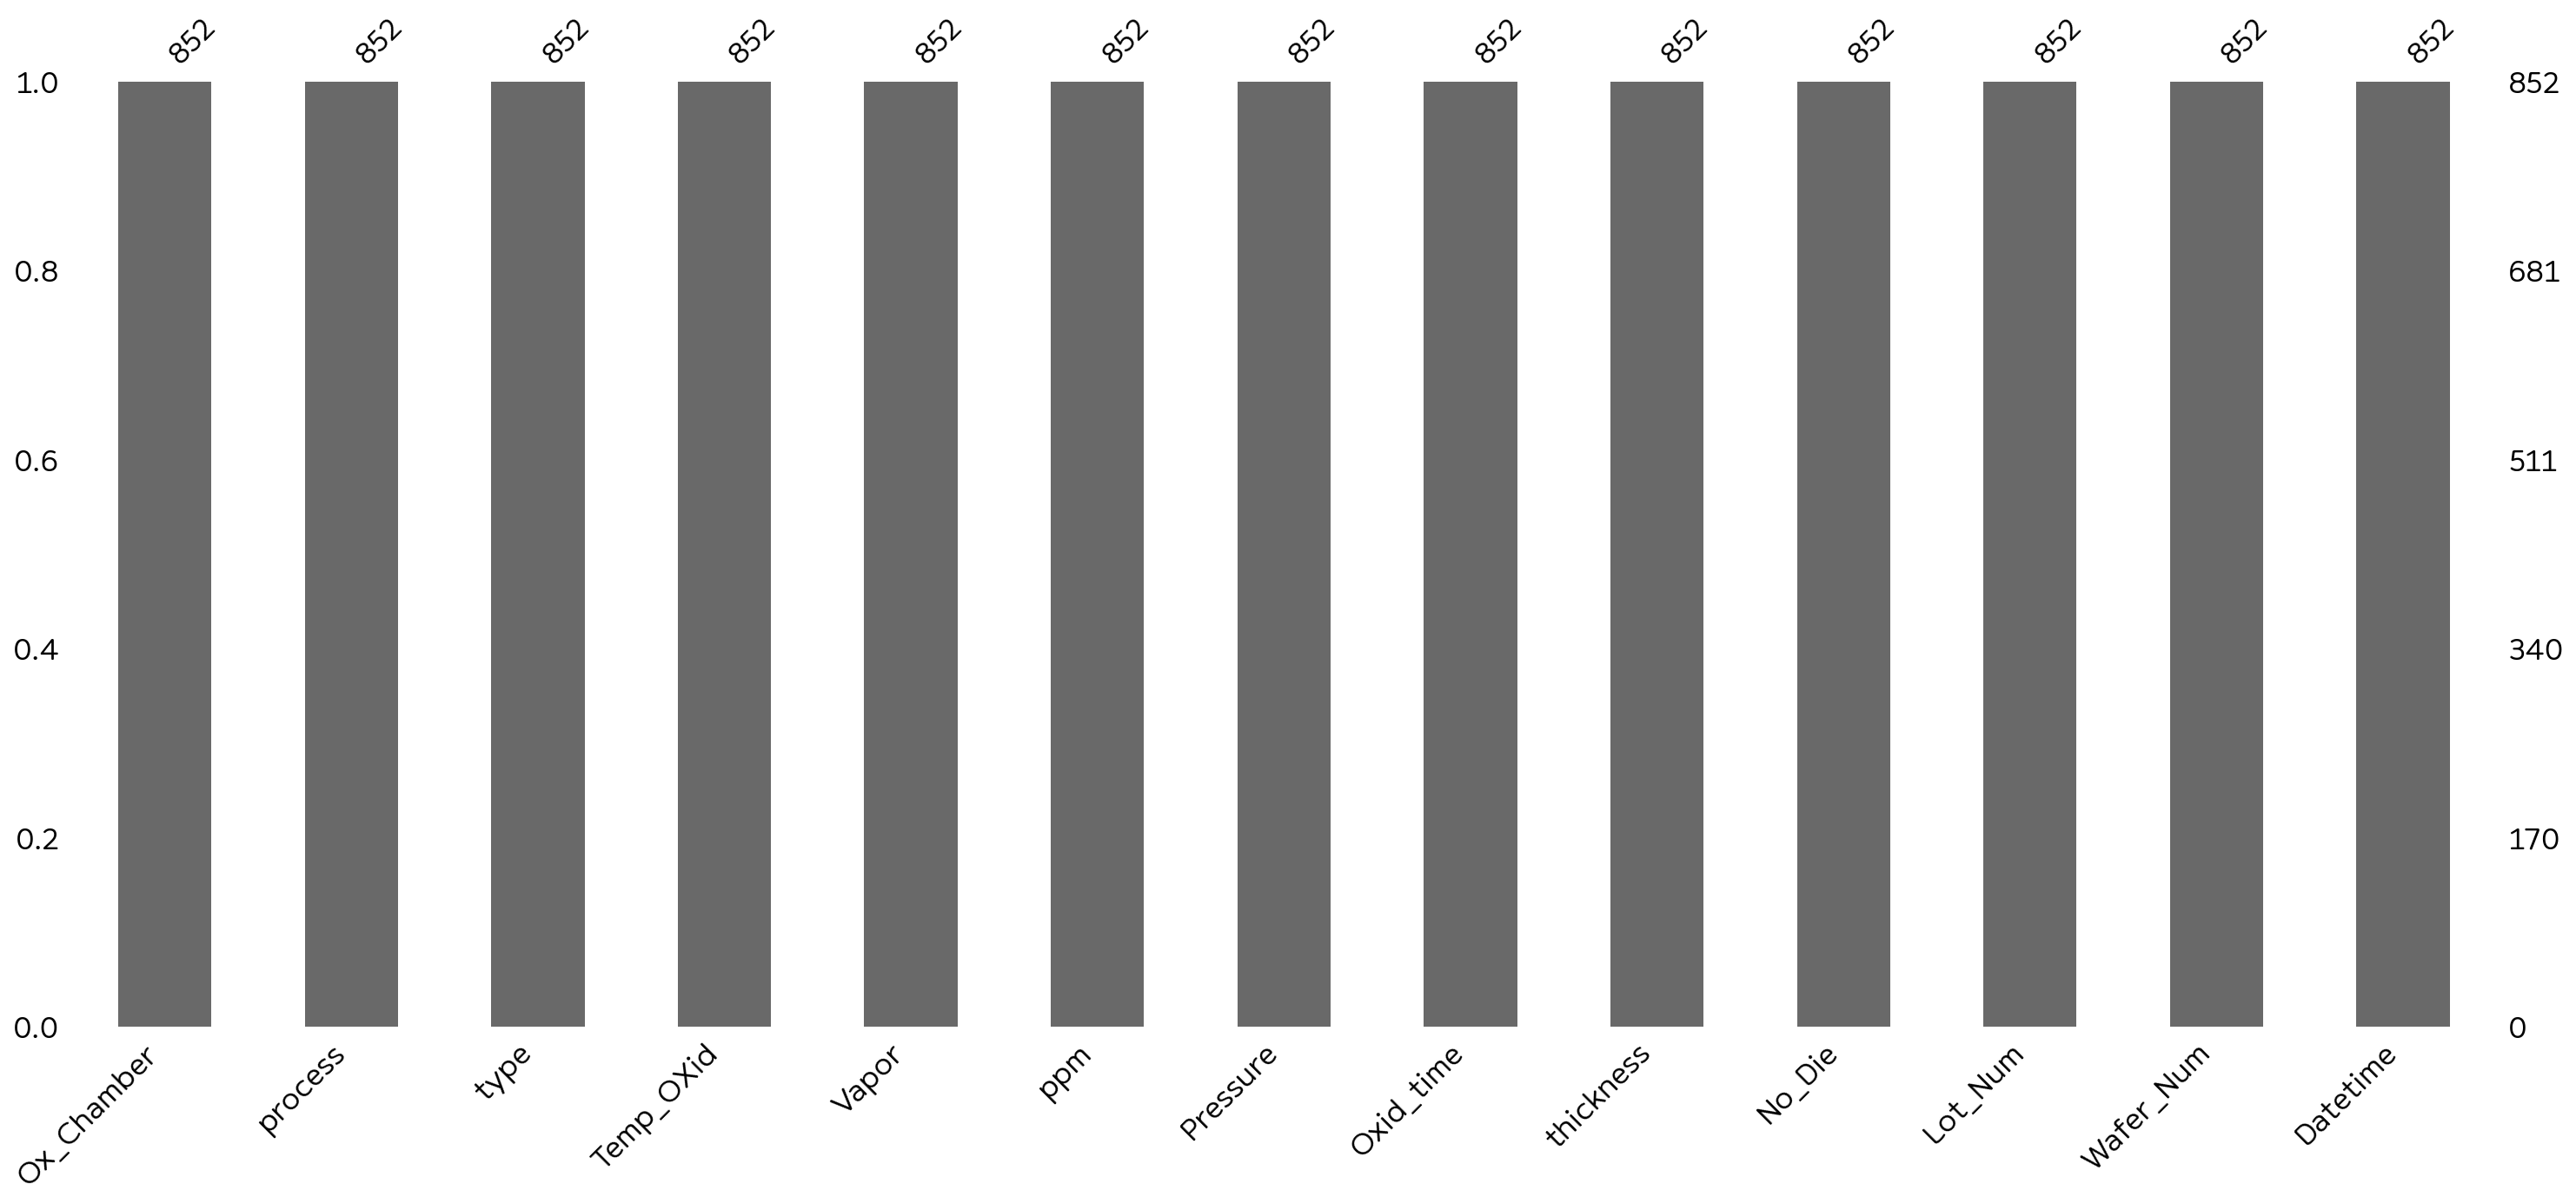

In [3]:
plt.figure(figsize=(8,5))
msno.bar(df_oxi)
plt.show()
# 일단 결측치는 없다.

### 이상치 제거

In [4]:
print(np.array(df_oxi.columns))

['Ox_Chamber' 'process' 'type' 'Temp_OXid' 'Vapor' 'ppm' 'Pressure'
 'Oxid_time' 'thickness' 'No_Die' 'Lot_Num' 'Wafer_Num' 'Datetime']


In [5]:
df_oxi.describe()
# 연속형 변수는 Ox_Chamber, Temp_OXid, ppm, Pressure, Oxid_time, thickness, Lot_Num, Wafer_Num

,Ox_Chamber,Temp_OXid,ppm,Pressure,Oxid_time,thickness,Lot_Num,Wafer_Num
count,852.00000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000
mean,2.00000,1064.415784,33.202242,0.211374,123.201878,710.926810,16.281690,13.894366
std,0.81265,149.550147,8.494070,0.009067,76.285130,8.082856,9.116841,7.785951
min,1.00000,862.011276,21.070000,0.180000,-6.000000,681.435000,1.000000,1.000000
25%,1.00000,874.756813,22.450000,0.205000,52.000000,706.313000,8.000000,7.000000
50%,2.00000,1069.240209,33.420000,0.213000,116.000000,711.590500,16.000000,14.000000
75%,3.00000,1189.172249,40.452500,0.217000,217.000000,715.595000,24.000000,21.000000
max,3.00000,1339.476675,49.910000,0.229000,291.000000,737.402000,32.000000,27.000000


<AxesSubplot:xlabel='Temp_OXid', ylabel='Density'>

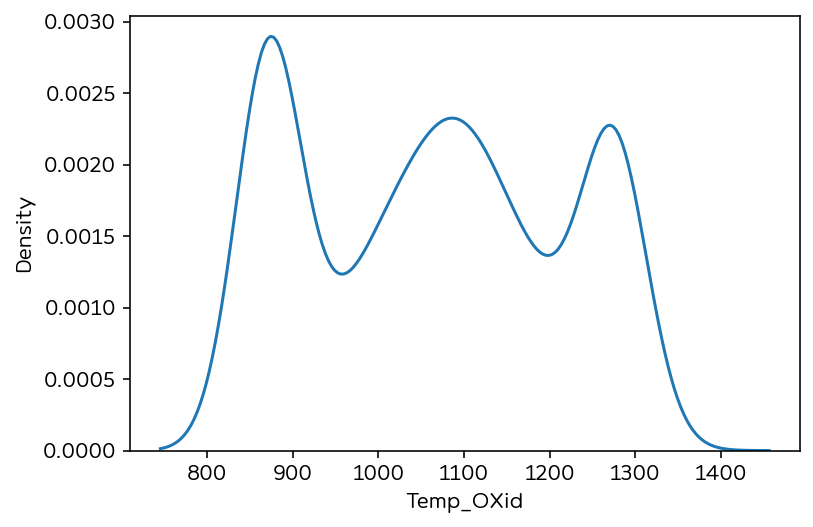

In [6]:
sns.kdeplot(df_oxi['Temp_OXid'])

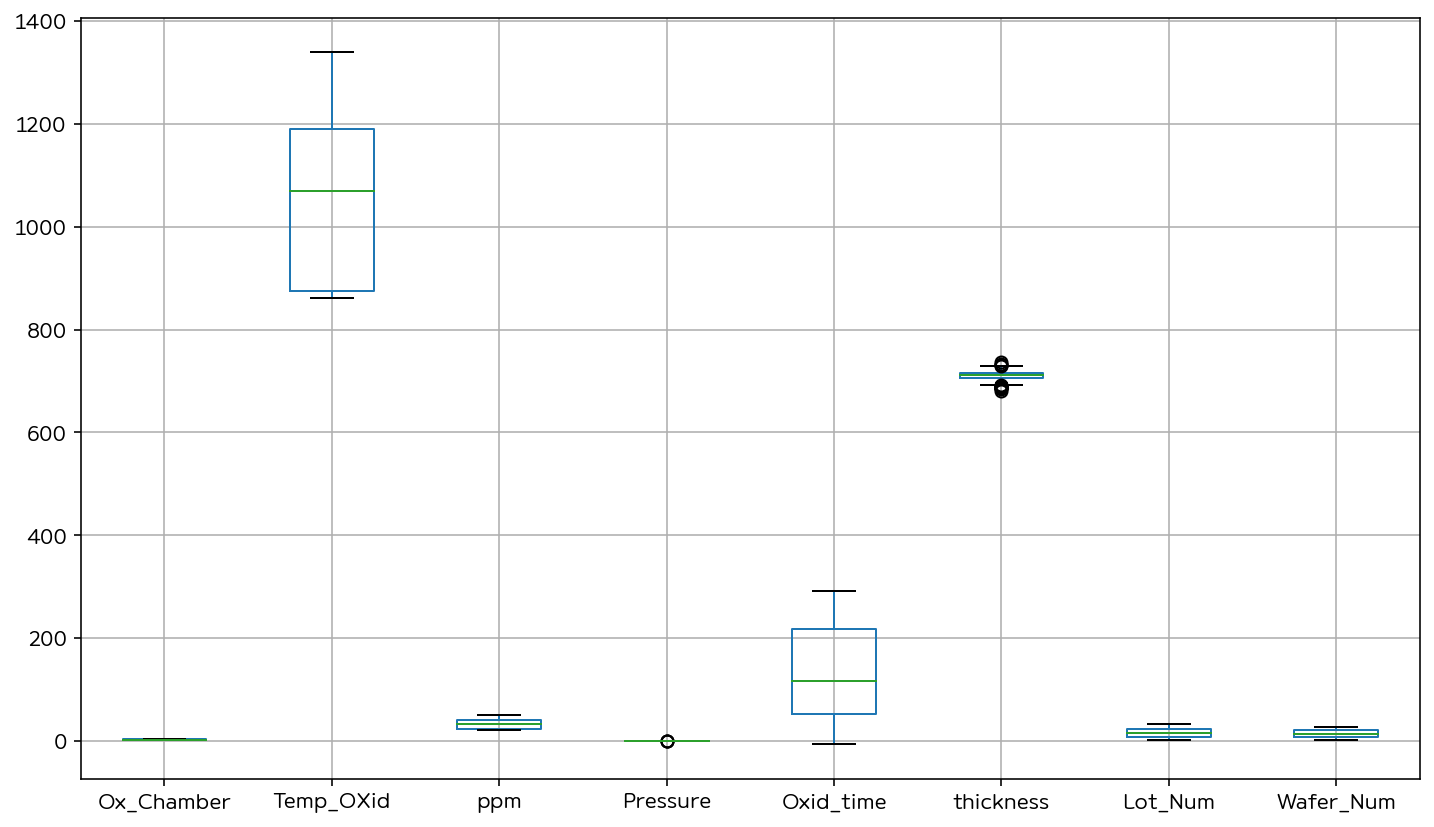

In [7]:
df_oxi.boxplot(figsize=(12,7))
plt.show()

In [8]:
# 사분위수를 이용해서 이상치를 제거해보자.
# aggfunc 정의
def remove_outlier(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    # print(q1, q3, lower_bound, upper_bound)
    
    mask = np.where((data>upper_bound) | (data<lower_bound), np.NaN, data)
    return mask

```python
np.percentile()

#주요인자
a : array_like
    Input array or object that can be converted to an array.
q : array_like of float
    Percentile or sequence of percentiles to compute, which must be between
    0 and 100 inclusive.
```

In [9]:
continuous_ls = list(df_oxi.columns)

In [10]:
continuous_ls = ['Ox_Chamber', 'Temp_OXid', 'ppm', 'Pressure', 'Oxid_time', 'thickness', 'Lot_Num', 'Wafer_Num']
for idx, val in enumerate(continuous_ls):
    df_oxi[val] = df_oxi[val].apply(remove_outlier)

In [11]:
df_oxi[df_oxi['Oxid_time'] < 0] = np.NaN # 시간이 0보다 작을 수 없으니 음수는 제거

In [12]:
df_oxi['Reinforcement'] = np.where(df_oxi['thickness'] >= 700., True, False)
df_oxi.head(3)

,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,No_Die,Lot_Num,Wafer_Num,Datetime,Reinforcement
0,1.0,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,NOLSM111,1.0,1.0,17-02-2019 PM 9:04:30,False
1,1.0,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,NOLSM212,1.0,2.0,17-02-2019 PM 9:04:30,False
2,1.0,Oxidation,dry,1062.467808,O2,39.51,0.217,128.0,705.471,NOLSM313,1.0,3.0,17-02-2019 PM 9:04:30,True


In [13]:
# 정상 wafer와 700nm 이하 wafer에 대해, oxidation 연속형 변수에 대해서 평균값 확인
df_oxi.pivot_table(index='Reinforcement')

# 산화 시간이 짧으면 불량이 생기나???

,Lot_Num,Ox_Chamber,Oxid_time,Pressure,Temp_OXid,Wafer_Num,ppm,thickness
Reinforcement,,,,,,,,
False,9.797468,1.962025,110.037975,0.207025,1078.988941,12.924051,33.810506,695.121772
True,16.941330,2.003911,125.555411,0.211896,1062.187836,14.048240,33.100561,712.652219


## Softbake Data

In [14]:
df_soft = pd.read_csv('../data/project01/Photo_Softbake_000.csv')
df_soft.drop('Unnamed: 0', axis=1, inplace=True)
df_soft.head()

,photo_soft_Chamber,process 2,resist_target,N2_HMDS,pressure_HMDS,temp_HMDS,temp_HMDS_bake,time_HMDS_bake,spin1,spin2,spin3,photoresist_bake,temp_softbake,time_softbake,No_Die,Lot_Num,Wafer_Num,Datetime
0,1,Photo,1.211940,13.891,15.025,20.000,198.792,90.001,504.589,4082.622,5184.620,5.044,90.894,30.009,NOLSM111,1,1,17-02-2019 PM 9:04:30
1,1,Photo,0.887720,14.722,15.059,19.995,198.747,89.998,492.196,3960.739,5065.197,5.058,92.334,29.997,NOLSM212,1,2,17-02-2019 PM 9:04:30
2,1,Photo,1.113156,19.205,14.964,19.997,202.139,90.000,499.886,3981.691,4873.417,5.151,91.868,30.005,NOLSM313,1,3,17-02-2019 PM 9:04:30
3,2,Photo,0.882195,16.368,14.944,19.998,199.649,90.001,505.249,3922.191,5131.972,5.069,91.881,29.997,NOLSM414,1,4,17-02-2019 PM 9:04:30
4,2,Photo,0.834001,13.926,14.933,20.002,204.544,90.001,501.089,4124.099,5108.355,5.055,91.212,30.001,NOLSM515,1,5,17-02-2019 PM 9:04:30


## Lithography Data

In [15]:
df_litho = pd.read_csv('../data/project01/Photo_lithography_000.csv')
df_litho.head(3)

,lithography_Chamber,Line_CD,Lamp,UV_type,Wavelength,Resolution,Energy_Exposure,No_Die,Lot_Num,Wafer_Num,Datetime
0,1,30.959,Hg-Arc,H,405,516.657,109.769,NOLSM111,1,1,17-02-2019 PM 9:04:30
1,2,29.653,Hg-Arc,H,405,501.894,107.102,NOLSM212,1,2,17-02-2019 PM 9:04:30
2,3,28.063,Hg-Arc,I,365,506.750,110.471,NOLSM313,1,3,17-02-2019 PM 9:04:30


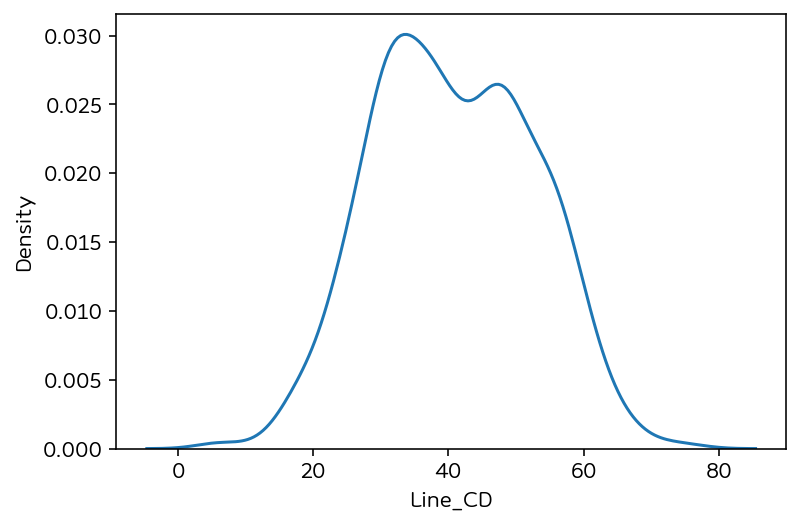

In [16]:
df_litho.describe()
sns.kdeplot(df_litho['Line_CD'])
plt.show()

### Line Critical Dimension으로 나누기 

In [17]:
df_litho['Range_check'] = np.where((df_litho['Line_CD'] >=25) & (df_litho['Line_CD'] <= 55), True, False)
df_litho.head(3)

,lithography_Chamber,Line_CD,Lamp,UV_type,Wavelength,Resolution,Energy_Exposure,No_Die,Lot_Num,Wafer_Num,Datetime,Range_check
0,1,30.959,Hg-Arc,H,405,516.657,109.769,NOLSM111,1,1,17-02-2019 PM 9:04:30,True
1,2,29.653,Hg-Arc,H,405,501.894,107.102,NOLSM212,1,2,17-02-2019 PM 9:04:30,True
2,3,28.063,Hg-Arc,I,365,506.750,110.471,NOLSM313,1,3,17-02-2019 PM 9:04:30,True


In [18]:
df_litho.pivot_table(index='Range_check', columns='UV_type', values='Datetime', aggfunc='count')

# H Type beam에서 False값이 높다.

UV_type,G,H,I
Range_check,,,
False,45,94,48
True,267,192,206


## Ethcing Data

In [19]:
df_ethc = pd.read_csv('../data/project01/Etching_000.csv')
df_ethc.drop('Unnamed: 0', axis=1, inplace=True)
df_ethc.head(3)

,Etching_Chamber,Process 3,Temp_Etching,Source_Power,Selectivity,No_Die,Lot_Num,Wafer_Num,Datetime,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1
0,3,Etching,70.878,50.851,1.047,NOLSM111,1,1,17-02-2019 PM 9:04:30,251.0,267.06,303.82,361.38
1,2,Etching,69.561,52.283,1.051,NOLSM212,1,2,17-02-2019 PM 9:04:30,317.0,332.74,369.31,426.11
2,1,Etching,70.968,51.610,1.017,NOLSM313,1,3,17-02-2019 PM 9:04:30,411.0,424.21,460.65,517.80


In [20]:
print(df_ethc.shape)
df_ethc.describe()

(852, 13)


,Etching_Chamber,Temp_Etching,Source_Power,Selectivity,Lot_Num,Wafer_Num,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1
count,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,851.000000,851.000000,851.000000,851.000000
mean,1.967136,71.147822,51.227459,1.032140,16.281690,13.894366,296.633373,311.276439,347.799401,404.940012
std,0.830584,0.824158,0.634215,0.016238,9.116841,7.785951,125.378446,125.714630,125.774630,125.790535
min,1.000000,68.150000,49.342000,0.984000,1.000000,1.000000,-49.000000,-34.650000,2.000000,59.380000
25%,1.000000,70.709750,50.794500,1.022000,8.000000,7.000000,202.000000,216.525000,252.880000,310.185000
50%,2.000000,71.220500,51.247000,1.033500,16.000000,14.000000,281.000000,295.970000,332.480000,389.630000
75%,3.000000,71.656500,51.698250,1.043000,24.000000,21.000000,372.000000,386.675000,423.050000,480.355000
max,3.000000,73.081000,53.272000,1.076000,32.000000,27.000000,687.000000,700.240000,736.510000,793.500000


### Etching 공정 데이터에서 Thin Film 값이 150nm 이하로 떨어지는 값을 제거
- Thin Film이 150nm 이상이 되어야 다음 공정이 가능하다.

In [21]:
for i in range(1,5):
    df_ethc[f'Thin Film {i}'] = np.where(df_ethc[f'Thin Film {i}']<150, np.NaN, df_ethc[f'Thin Film {i}'])

### Etching Rate
- $ ER = \frac{thin1 - thin4}{30} $ 이면

In [22]:
df_ethc['ER'] = (df_ethc['Thin Film 1'] - df_ethc['Thin Film 4']) /30
df_ethc.head()

,Etching_Chamber,Process 3,Temp_Etching,Source_Power,Selectivity,No_Die,Lot_Num,Wafer_Num,Datetime,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1,ER
0,3,Etching,70.878,50.851,1.047,NOLSM111,1,1,17-02-2019 PM 9:04:30,251.0,267.06,303.82,361.38,3.679333
1,2,Etching,69.561,52.283,1.051,NOLSM212,1,2,17-02-2019 PM 9:04:30,317.0,332.74,369.31,426.11,3.637000
2,1,Etching,70.968,51.610,1.017,NOLSM313,1,3,17-02-2019 PM 9:04:30,411.0,424.21,460.65,517.80,3.560000
3,1,Etching,70.146,51.286,1.027,NOLSM414,1,4,17-02-2019 PM 9:04:30,256.0,272.28,308.56,365.93,3.664333
4,2,Etching,71.174,51.996,1.050,NOLSM515,1,5,17-02-2019 PM 9:04:30,419.0,434.98,471.65,528.85,3.661667


## Implantation

### 음수 값으로 측정되는 이상치 제거(Missing Value로 처리)

In [23]:
df_imp = pd.read_csv('../data/project01/Implant_000.csv')
df_imp.head()

,Chamber_Num,process4,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Current,Temp_implantation,Furance_Temp,RTA_Temp,No_Die,Lot_Num,Wafer_Num,Datetime
0,3,Implantation,9.997373e+15,1.346079e+17,3.468281e+17,3.002593e+17,6.000007e+17,31574.410,0.01,102.847,885.0,154,NOLSM111,1,1,17-02-2019 ?? 9:04:30
1,2,Implantation,9.705928e+15,1.389326e+17,3.838008e+17,3.017903e+17,6.000012e+17,31580.213,0.01,104.323,919.0,154,NOLSM212,1,2,17-02-2019 ?? 9:04:30
2,1,Implantation,1.761358e+16,8.782248e+16,6.014497e+17,2.994231e+17,6.000002e+17,32162.414,0.01,100.605,916.0,155,NOLSM313,1,3,17-02-2019 ?? 9:04:30
3,1,Implantation,1.148303e+16,9.776566e+16,6.646884e+16,2.991354e+17,6.000003e+17,32874.925,0.01,101.739,911.0,156,NOLSM414,1,4,17-02-2019 ?? 9:04:30
4,2,Implantation,9.769204e+15,1.222219e+17,2.496090e+17,3.005576e+17,6.000013e+17,30985.928,0.01,106.422,872.0,155,NOLSM515,1,5,17-02-2019 ?? 9:04:30


In [24]:
df_imp.describe()
# 음수값이 나오는 컬럼은 Flux90s, Flux160s임

,Chamber_Num,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Current,Temp_implantation,Furance_Temp,RTA_Temp,Lot_Num,Wafer_Num
count,852.000000,8.510000e+02,8.510000e+02,8.510000e+02,8.520000e+02,8.520000e+02,852.000000,8.520000e+02,852.000000,851.000000,852.000000,852.000000,852.000000
mean,1.967136,1.186913e+16,7.982876e+16,4.483541e+17,3.002006e+17,5.999997e+17,32007.862815,1.000000e-02,103.161261,901.128085,154.696009,16.281690,13.894366
std,0.830584,4.603012e+15,5.478891e+16,3.322530e+17,1.145362e+15,1.080690e+12,588.322496,1.614240e-16,1.654830,18.487803,2.420114,9.116841,7.785951
min,1.000000,1.967326e+15,-4.117940e+16,-6.930960e+16,2.963401e+17,5.999965e+17,29604.262000,1.000000e-02,97.744000,854.000000,148.000000,1.000000,1.000000
25%,1.000000,8.590656e+15,3.081442e+16,1.319423e+17,2.994309e+17,5.999990e+17,31640.161000,1.000000e-02,102.063500,890.000000,153.000000,8.000000,7.000000
50%,2.000000,1.177267e+16,8.132774e+16,4.571101e+17,3.001862e+17,5.999997e+17,32200.488500,1.000000e-02,103.295500,904.000000,155.000000,16.000000,14.000000
75%,3.000000,1.516101e+16,1.209841e+17,6.816896e+17,3.009426e+17,6.000004e+17,32420.668750,1.000000e-02,104.322000,915.000000,156.000000,24.000000,21.000000
max,3.000000,2.403938e+16,2.720974e+17,1.401808e+18,3.036145e+17,6.000025e+17,33675.551000,1.000000e-02,107.376000,944.000000,162.000000,32.000000,27.000000


In [25]:
df_imp[df_imp['Flux60s'].isnull()]
# 702번 인덱스의 값엔 NaN이 존재.

,Chamber_Num,process4,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Current,Temp_implantation,Furance_Temp,RTA_Temp,No_Die,Lot_Num,Wafer_Num,Datetime
702,2,Implantation,NaN,NaN,NaN,3.002952e+17,5.999998e+17,32437.886,0.01,104.475,NaN,157,NOLSM703271,27,1,23-02-2019 ?? 9:04:30


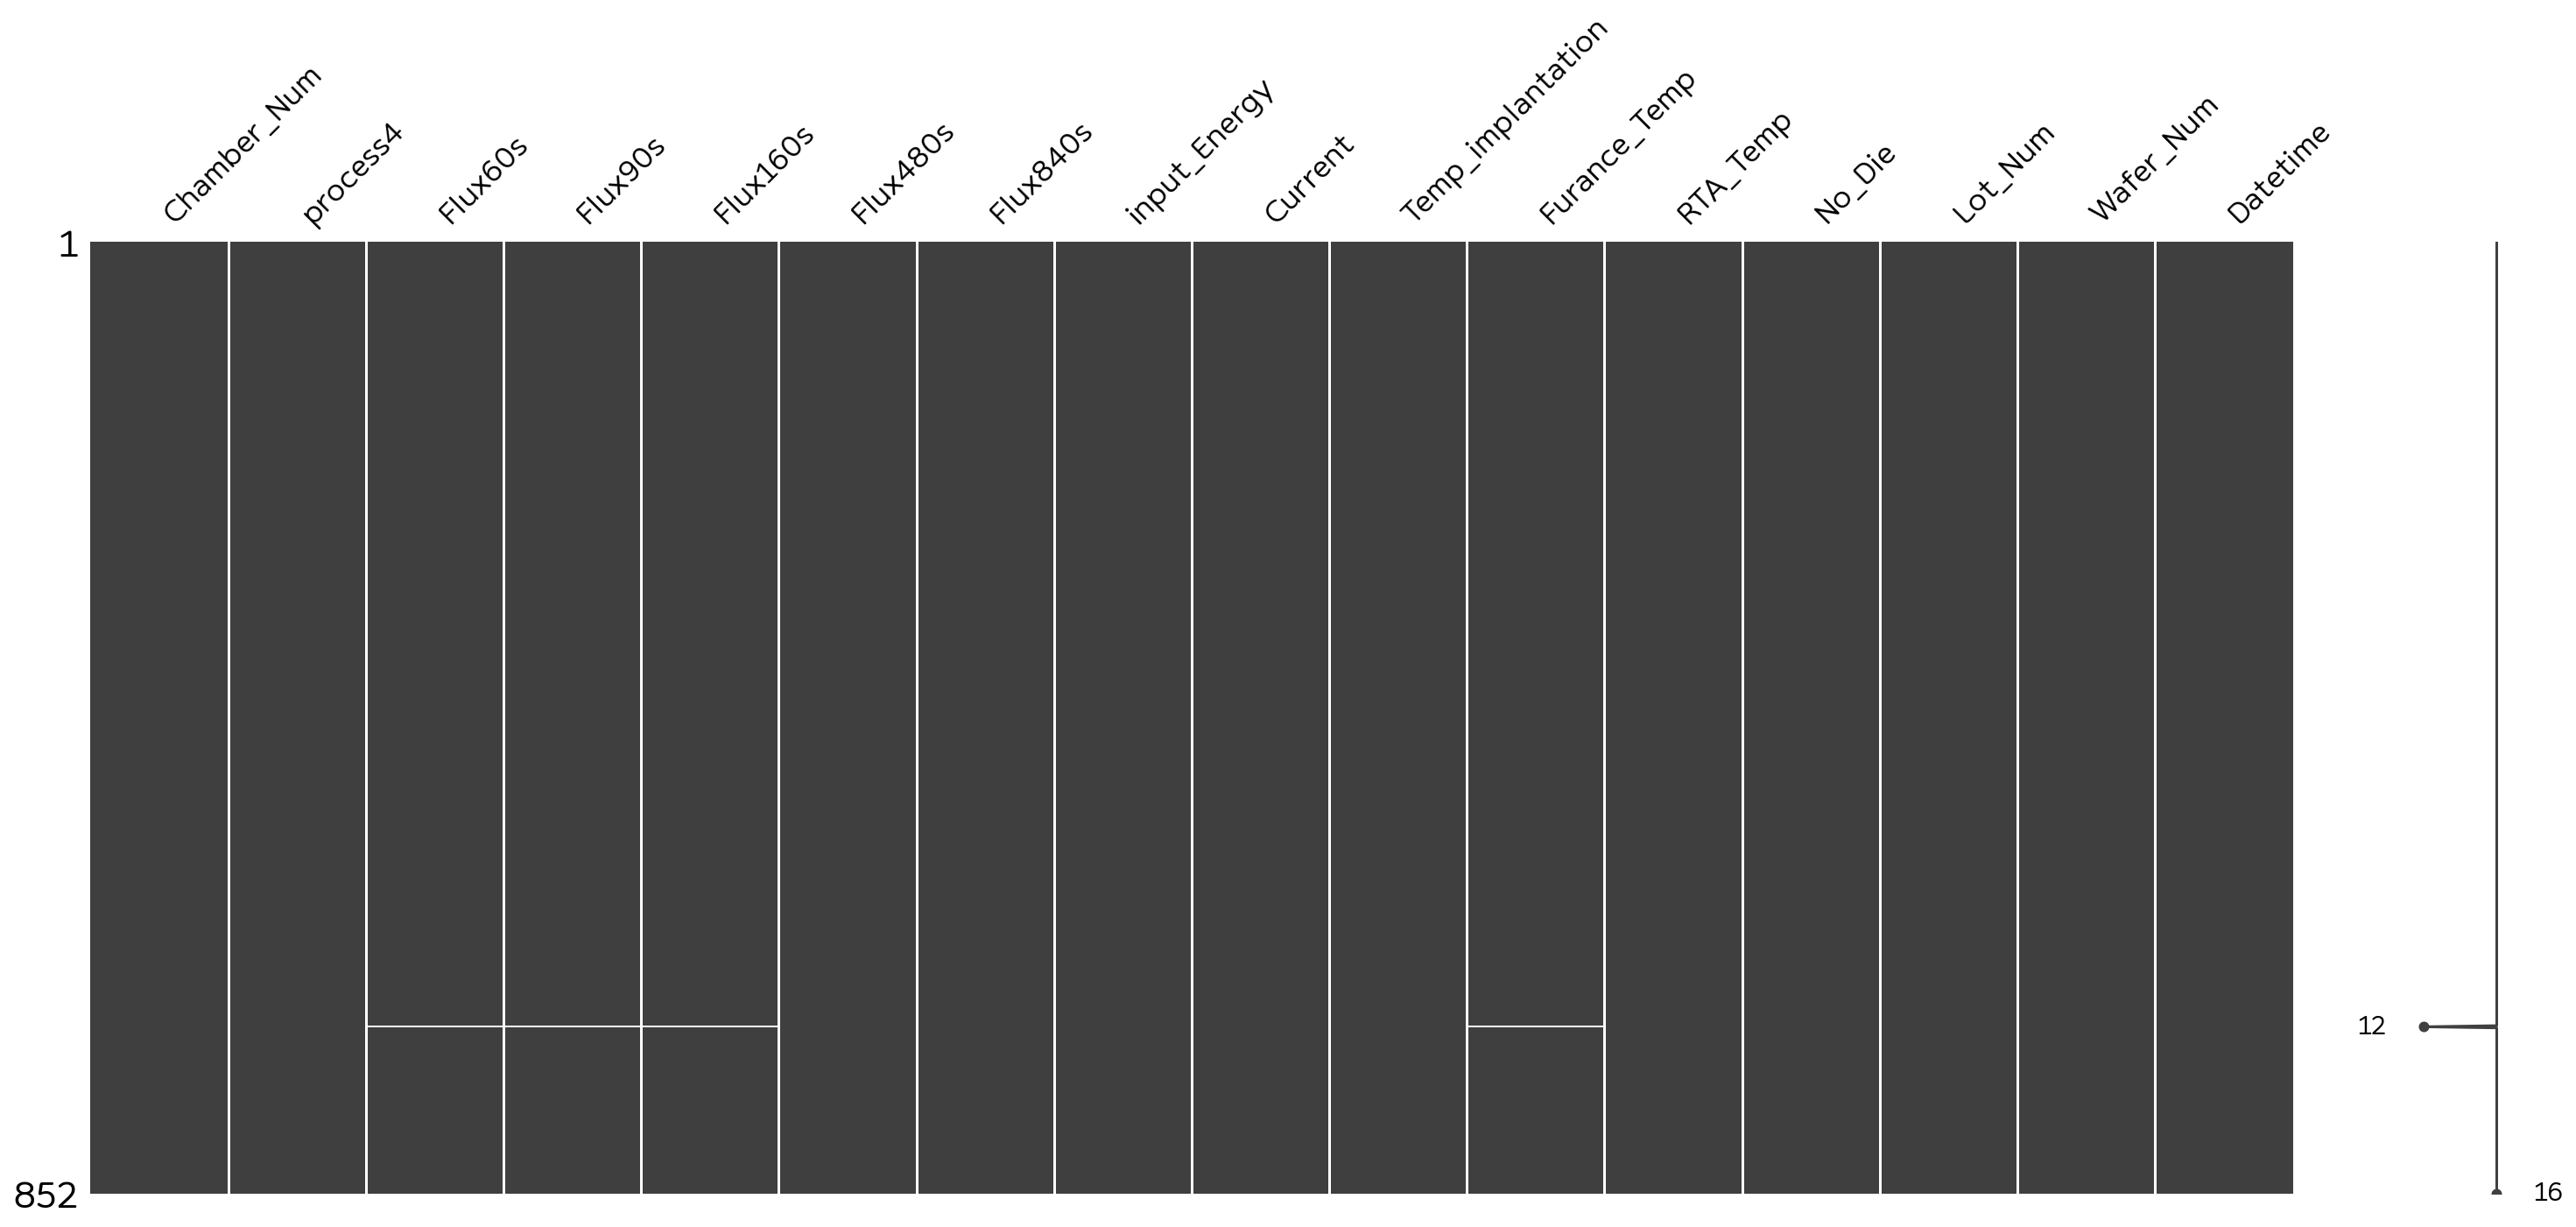

In [26]:
msno.matrix(df_imp)
plt.show()

In [27]:
df_imp['Flux90s'] = np.where(df_imp['Flux90s']<0, np.NaN, df_imp['Flux90s'])
df_imp['Flux160s'] = np.where(df_imp['Flux160s']<0, np.NaN, df_imp['Flux160s'])

In [28]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Chamber_Num        852 non-null    int64  
 1   process4           852 non-null    object 
 2   Flux60s            851 non-null    float64
 3   Flux90s            843 non-null    float64
 4   Flux160s           847 non-null    float64
 5   Flux480s           852 non-null    float64
 6   Flux840s           852 non-null    float64
 7   input_Energy       852 non-null    float64
 8   Current            852 non-null    float64
 9   Temp_implantation  852 non-null    float64
 10  Furance_Temp       851 non-null    float64
 11  RTA_Temp           852 non-null    int64  
 12  No_Die             852 non-null    object 
 13  Lot_Num            852 non-null    int64  
 14  Wafer_Num          852 non-null    int64  
 15  Datetime           852 non-null    object 
dtypes: float64(9), int64(4), o

## Inspection

In [29]:
df_ins = pd.read_csv('../data/project01/Inspect_000.csv')
df_ins.head()

,Target,No_Die,Lot_Num,Wafer_Num,Datetime,Error_message,Wafer_map
0,96,NOLSM111,1,1,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...
1,102,NOLSM212,1,2,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...
2,95,NOLSM313,1,3,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...
3,117,NOLSM414,1,4,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...
4,143,NOLSM515,1,5,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...


### 에러 메시지가 있으면 1, 없으면 0으로 이산형 변수의 새 컬럼 생성

In [30]:
df_ins['target_binom'] = np.where(df_ins['Error_message']=='none', 0.0, 1.0)
df_ins.head()

,Target,No_Die,Lot_Num,Wafer_Num,Datetime,Error_message,Wafer_map,target_binom
0,96,NOLSM111,1,1,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0
1,102,NOLSM212,1,2,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0
2,95,NOLSM313,1,3,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0
3,117,NOLSM414,1,4,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0
4,143,NOLSM515,1,5,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0


In [31]:
df_ins['target_binom'].value_counts()

0.0    786
1.0     66
Name: target_binom, dtype: int64

# 3. 데이터 병합

### 아래의 각 테이블을 Key : No_Die로 left join
- df_ethc
- df_imp
- df_ins
- df_litho
- df_oxi

In [32]:
df1 = pd.merge(df_ethc, df_imp, on='No_Die', how='left')
df1 = pd.merge(df1, df_ins, on='No_Die', how='left')
df1 = pd.merge(df1, df_litho, on='No_Die', how='left')
df1 = pd.merge(df1, df_oxi, on='No_Die', how='left')
df1 = pd.merge(df1, df_soft, on='No_Die', how='left')
df1.head()

C:\Users\Jay\AppData\Local\Temp/ipykernel_20084/629785933.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Wafer_Num_x', 'Datetime_x', 'Lot_Num_x'} in the result is deprecated and will raise a MergeError in a future version.
  df1 = pd.merge(df1, df_litho, on='No_Die', how='left')
C:\Users\Jay\AppData\Local\Temp/ipykernel_20084/629785933.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Wafer_Num_x', 'Datetime_x', 'Lot_Num_x'} in the result is deprecated and will raise a MergeError in a future version.
  df1 = pd.merge(df1, df_soft, on='No_Die', how='left')


,Etching_Chamber,Process 3,Temp_Etching,Source_Power,Selectivity,No_Die,Lot_Num_x,Wafer_Num_x,Datetime_x,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1,ER,Chamber_Num,process4,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Current,Temp_implantation,Furance_Temp,RTA_Temp,Lot_Num_y,Wafer_Num_y,Datetime_y,Target,Lot_Num_x,Wafer_Num_x,Datetime_x,Error_message,Wafer_map,target_binom,lithography_Chamber,Line_CD,Lamp,UV_type,Wavelength,Resolution,Energy_Exposure,Lot_Num_y,Wafer_Num_y,Datetime_y,Range_check,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,Lot_Num_x,Wafer_Num_x,Datetime_x,Reinforcement,photo_soft_Chamber,process 2,resist_target,N2_HMDS,pressure_HMDS,temp_HMDS,temp_HMDS_bake,time_HMDS_bake,spin1,spin2,spin3,photoresist_bake,temp_softbake,time_softbake,Lot_Num_y,Wafer_Num_y,Datetime_y
0,3,Etching,70.878,50.851,1.047,NOLSM111,1,1,17-02-2019 PM 9:04:30,251.0,267.06,303.82,361.38,3.679333,3,Implantation,9.997373e+15,1.346079e+17,3.468281e+17,3.002593e+17,6.000007e+17,31574.410,0.01,102.847,885.0,154,1,1,17-02-2019 ?? 9:04:30,96,1,1,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,1,30.959,Hg-Arc,H,405,516.657,109.769,1,1,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,1.0,1.0,17-02-2019 PM 9:04:30,False,1,Photo,1.211940,13.891,15.025,20.000,198.792,90.001,504.589,4082.622,5184.620,5.044,90.894,30.009,1,1,17-02-2019 PM 9:04:30
1,2,Etching,69.561,52.283,1.051,NOLSM212,1,2,17-02-2019 PM 9:04:30,317.0,332.74,369.31,426.11,3.637000,2,Implantation,9.705928e+15,1.389326e+17,3.838008e+17,3.017903e+17,6.000012e+17,31580.213,0.01,104.323,919.0,154,1,2,17-02-2019 ?? 9:04:30,102,1,2,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,2,29.653,Hg-Arc,H,405,501.894,107.102,1,2,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,1.0,2.0,17-02-2019 PM 9:04:30,False,1,Photo,0.887720,14.722,15.059,19.995,198.747,89.998,492.196,3960.739,5065.197,5.058,92.334,29.997,1,2,17-02-2019 PM 9:04:30
2,1,Etching,70.968,51.610,1.017,NOLSM313,1,3,17-02-2019 PM 9:04:30,411.0,424.21,460.65,517.80,3.560000,1,Implantation,1.761358e+16,8.782248e+16,6.014497e+17,2.994231e+17,6.000002e+17,32162.414,0.01,100.605,916.0,155,1,3,17-02-2019 ?? 9:04:30,95,1,3,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,3,28.063,Hg-Arc,I,365,506.750,110.471,1,3,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1062.467808,O2,39.51,0.217,128.0,705.471,1.0,3.0,17-02-2019 PM 9:04:30,True,1,Photo,1.113156,19.205,14.964,19.997,202.139,90.000,499.886,3981.691,4873.417,5.151,91.868,30.005,1,3,17-02-2019 PM 9:04:30
3,1,Etching,70.146,51.286,1.027,NOLSM414,1,4,17-02-2019 PM 9:04:30,256.0,272.28,308.56,365.93,3.664333,1,Implantation,1.148303e+16,9.776566e+16,6.646884e+16,2.991354e+17,6.000003e+17,32874.925,0.01,101.739,911.0,156,1,4,17-02-2019 ?? 9:04:30,117,1,4,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,1,31.556,Hg-Arc,I,365,537.603,107.072,1,4,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1114.704773,O2,32.88,0.201,90.0,710.772,1.0,4.0,17-02-2019 PM 9:04:30,True,2,Photo,0.882195,16.368,14.944,19.998,199.649,90.001,505.249,3922.191,5131.972,5.069,91.881,29.997,1,4,17-02-2019 PM 9:04:30
4,2,Etching,71.174,51.996,1.050,NOLSM515,1,5,17-02-2019 PM 9:04:30,419.0,434.98,471.65,528.85,3.661667,2,Implantation,9.769204e+15,1.222219e+17,2.496090e+17,3.005576e+17,6.000013e+17,30985.928,0.01,106.422,872.0,155,1,5,17-02-2019 ?? 9:04:30,143,1,5,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,2,31.969,Hg-Arc,I,365,560.574,108.073,1,5,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,989.411946,O2,38.11,0.204,98.0,716.975,1.0,5.0,17-02-2019 PM 9:04:30,True,2,Photo,0.834001,13.926,14.933,20.002,204.544,90.001,501.089,4124.099,5108.355,5.055,91.212,30.001,1,5,17-02-2019 PM 9:04:30


In [33]:
print(df1.shape)

(852, 77)


### 병합된 데이터에서 null값 한번에 제거

In [34]:
df2 = df1.dropna()
df2.shape

(759, 77)

In [35]:
df2.isnull().sum()

Etching_Chamber        0
Process 3              0
Temp_Etching           0
Source_Power           0
Selectivity            0
No_Die                 0
Lot_Num_x              0
Wafer_Num_x            0
Datetime_x             0
Thin Film 4            0
Thin Film 3            0
Thin Film 2            0
Thin Film 1            0
ER                     0
Chamber_Num            0
process4               0
Flux60s                0
Flux90s                0
Flux160s               0
Flux480s               0
Flux840s               0
input_Energy           0
Current                0
Temp_implantation      0
Furance_Temp           0
RTA_Temp               0
Lot_Num_y              0
Wafer_Num_y            0
Datetime_y             0
Target                 0
Lot_Num_x              0
Wafer_Num_x            0
Datetime_x             0
Error_message          0
Wafer_map              0
target_binom           0
lithography_Chamber    0
Line_CD                0
Lamp                   0
UV_type                0


# 4. 병합 데이터 전처리

In [36]:
# print(df2[['Ox_Chamber', 'photo_soft_Chamber', 'lithography_Chamber', 'Etching_Chamber', 'Chamber_Num']])
df2['Ox_Chamber'] = df2['Ox_Chamber'].astype('int32').astype(str)
df2['photo_soft_Chamber'] = df2['photo_soft_Chamber'].astype(str)
df2['lithography_Chamber'] = df2['lithography_Chamber'].astype(str)
df2['Etching_Chamber'] = df2['Etching_Chamber'].astype(str)
df2['Chamber_Num'] = df2['Chamber_Num'].astype(str)

C:\Users\Jay\AppData\Local\Temp/ipykernel_20084/1032995847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Ox_Chamber'] = df2['Ox_Chamber'].astype('int32').astype(str)
C:\Users\Jay\AppData\Local\Temp/ipykernel_20084/1032995847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['photo_soft_Chamber'] = df2['photo_soft_Chamber'].astype(str)
C:\Users\Jay\AppData\Local\Temp/ipykernel_20084/1032995847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [37]:
df2['Chamber_Route'] = 'route_'+df2['Ox_Chamber']+df2['photo_soft_Chamber']+df2['lithography_Chamber']+df2['Etching_Chamber']+df2['Chamber_Num']
# df2['Chamber_Route']

C:\Users\Jay\AppData\Local\Temp/ipykernel_20084/2561676139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Chamber_Route'] = 'route_'+df2['Ox_Chamber']+df2['photo_soft_Chamber']+df2['lithography_Chamber']+df2['Etching_Chamber']+df2['Chamber_Num']


### 불필요한 공정변수 제거 후, 데이터 파일로 저장

In [38]:
df3 = df2.drop(columns=['Lot_Num_x', 'Wafer_Num_x', 'Datetime_x', 
                        'Lot_Num_y', 'Wafer_Num_y', 'Datetime_y', 'Lamp', 'Wafer_map', 'Current'])
print(df3.shape)

(759, 57)


In [39]:
df3.to_csv('preprocessing_data.csv')

In [40]:
df2.shape

(759, 78)

# 5. 데이터 시각화 및 가설검증

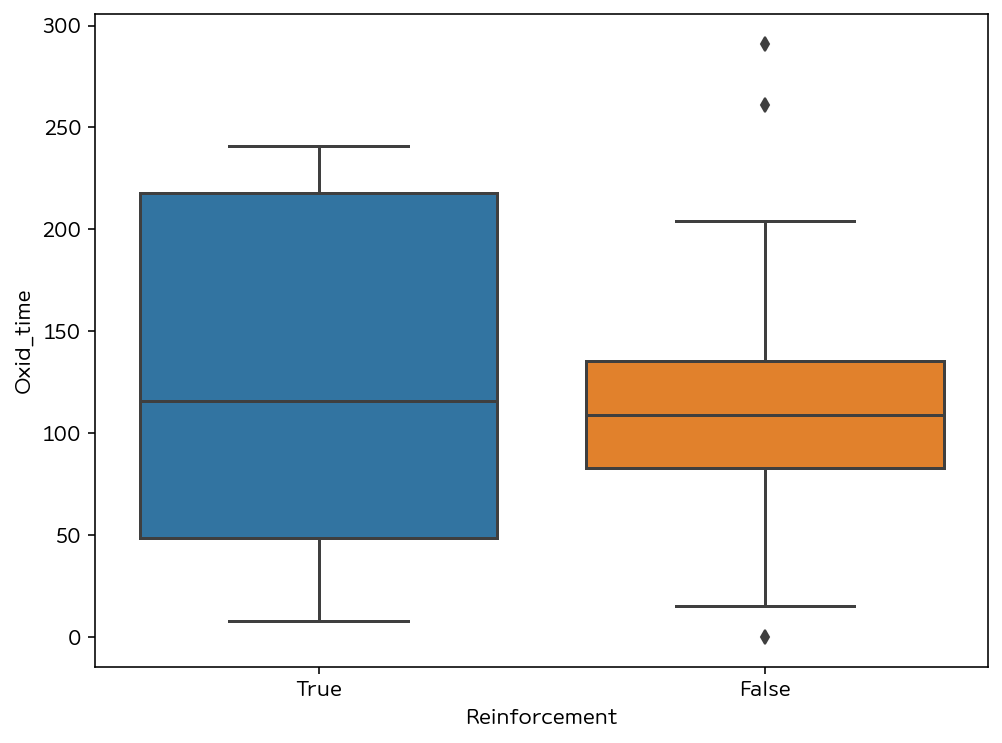

In [41]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df3['Reinforcement'], y=df3['Oxid_time'], order=[True, False])
plt.show()

In [42]:
from scipy import stats

<AxesSubplot:xlabel='Oxid_time', ylabel='Count'>

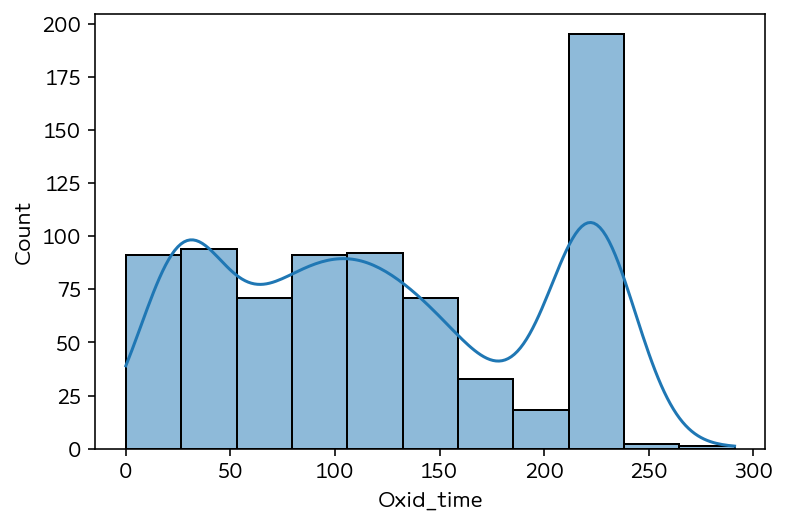

In [43]:
sns.histplot(x=df3['Oxid_time'],kde=True)

In [44]:
a= stats.normaltest(df3['Oxid_time'])
a

NormaltestResult(statistic=7551.524290228628, pvalue=0.0)

### 보강 여부에 따른 Oxidation Time의 비모수적 검정 실시(Oxidation Time이 비정규분포를 가정)

In [45]:
stats.ranksums(df3['Reinforcement'], df3['Oxid_time'])

RanksumsResult(statistic=-33.64589142300497, pvalue=3.5806148101000696e-248)

### 보강 여부에 따른 Oxidation Time의 등분산 검정 실시Oxidation Time이 비정규를 가정)

In [46]:
stats.levene(df3['Reinforcement'], df3['Oxid_time'])

LeveneResult(statistic=2173.1844060834087, pvalue=4.602723365965887e-295)

### 보강 여부에 따른 Oxidation Time의 이분산 가정 Two Sample T Test 실시

In [47]:
stats.ttest_ind(df3['Reinforcement'], df3['Oxid_time'])

Ttest_indResult(statistic=-44.90781845945852, pvalue=8.649180552050105e-281)

### UV Tpye에 따른 Out of Range의 유의미한 차이 확인

<AxesSubplot:xlabel='UV_type', ylabel='count'>

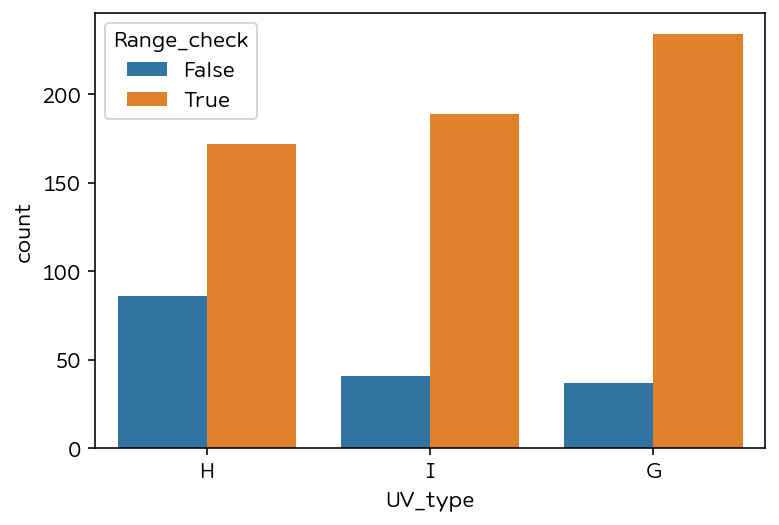

In [48]:
sns.countplot(x=df3["UV_type"], hue=df3['Range_check'])

In [49]:
df_contingency = df3.pivot_table(index='UV_type', columns='Range_check')['ER']
df_contingency

Range_check,False,True
UV_type,,
G,3.601207,3.607161
H,3.621411,3.619093
I,3.606146,3.610744


In [50]:
stats.chi2_contingency(df_contingency)

(5.45967313330836e-06,
 0.9999972701671593,
 2,
 array([[3.60281435, 3.60555382],
        [3.6188761 , 3.62162778],
        [3.60707395, 3.60981666]]))

### Etching Rate와 Target의 상관성 확인

C:\Users\Jay\anaconda3\envs\py38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


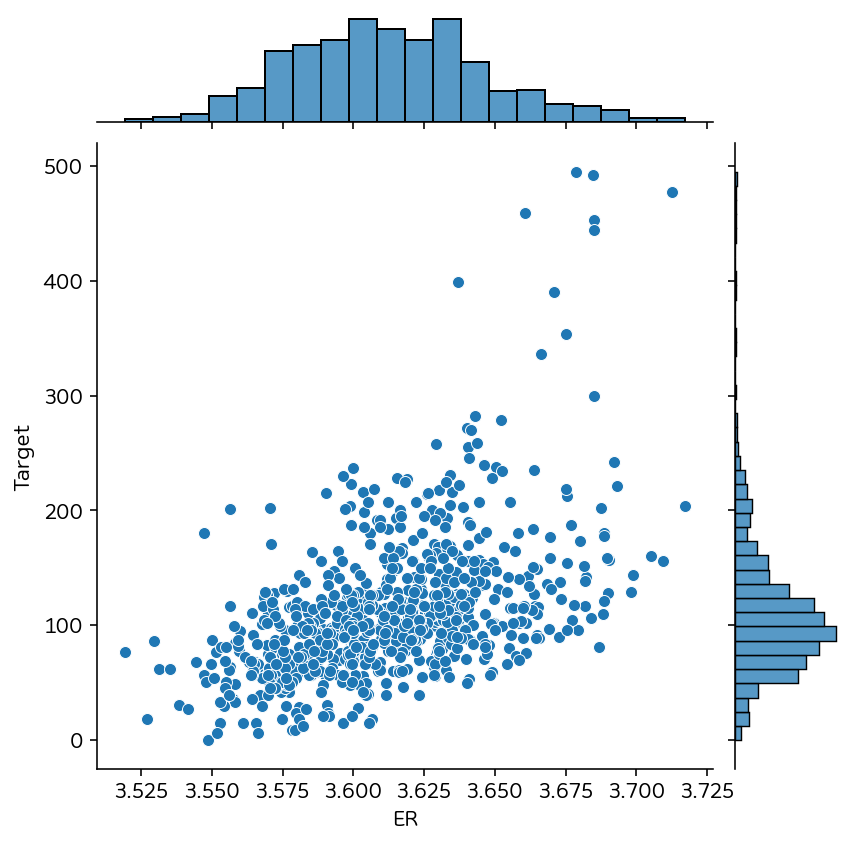

In [51]:
sns.jointplot(df3['ER'], df3['Target'])
plt.show()

### 공정 경로 별 Wafer 생산량 계산

In [52]:
a, b = df3['Chamber_Route'].value_counts().index, df3['Chamber_Route'].value_counts().values
dic = {'Chamber_Route':a, 'count':b}
Chamber_Route_count = pd.DataFrame(dic)

In [53]:
Chamber_Route_count = Chamber_Route_count.sort_values(by='Chamber_Route')
Chamber_Route_count.reset_index(drop=True, inplace=True)
Chamber_Route_count.head()

,Chamber_Route,count
0,route_11111,15
1,route_11133,14
2,route_11222,25
3,route_11311,17
4,route_11333,15


In [54]:
Chamber_Route_count

,Chamber_Route,count
0,route_11111,15
1,route_11133,14
2,route_11222,25
3,route_11311,17
4,route_11333,15
5,route_12111,18
6,route_12133,14
7,route_12222,20
8,route_12311,15
9,route_12333,16


### 공정 경로 별 Wafer 생산량에 대한 시각화

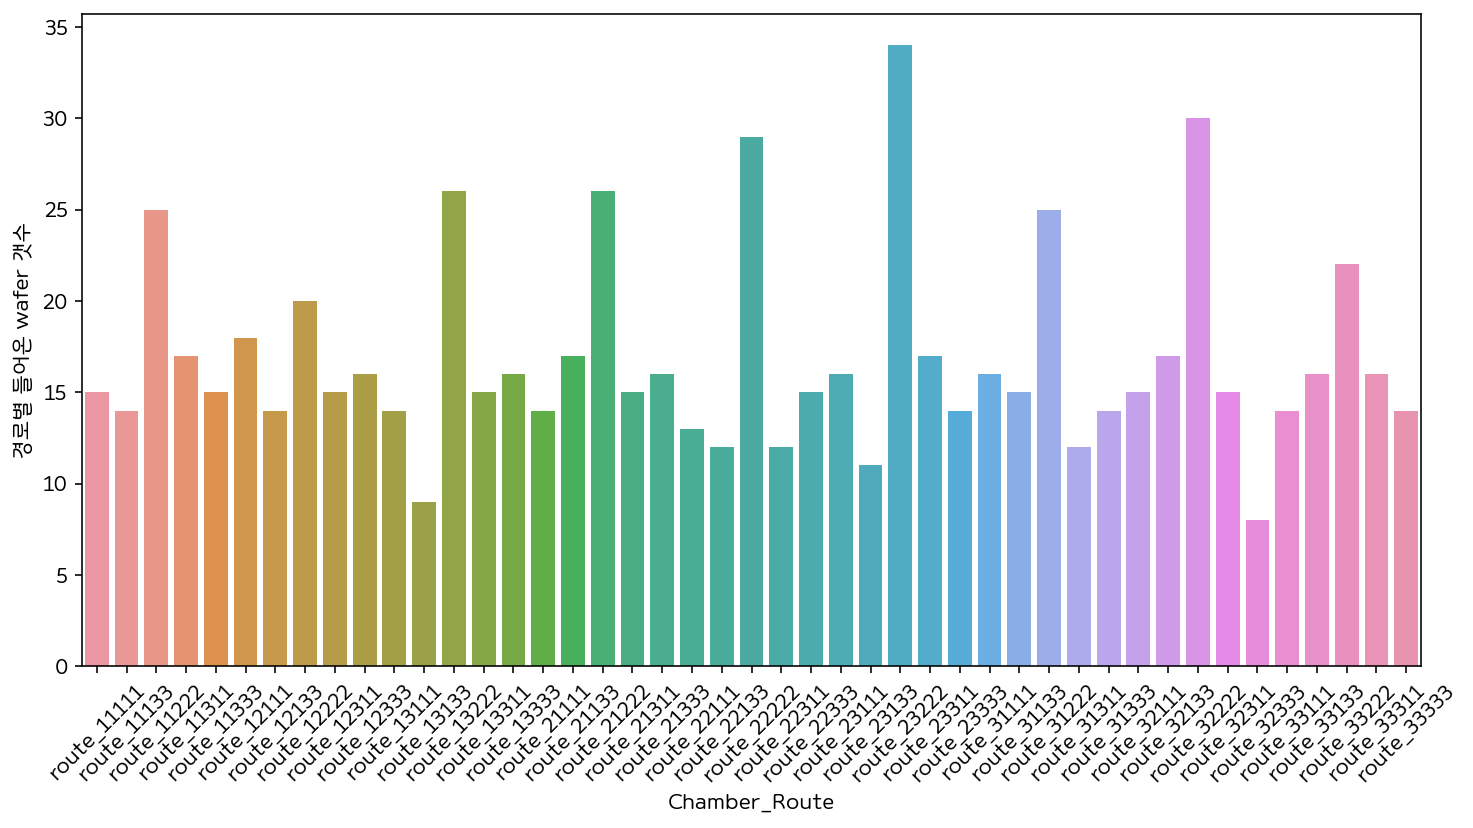

In [55]:
plt.figure(figsize=(12,6))
sns.barplot(data=Chamber_Route_count, x='Chamber_Route', y='count')
# sns.countplot(data=Chamber_Route_count, x='Chamber_Route')
plt.xticks(rotation=45)
plt.ylabel('경로별 들어온 wafer 갯수')
plt.show()

### 공정 경로 별 Wafer 내 불량 Chip 개수 계산

In [56]:
temp = df3.pivot_table(index='Chamber_Route', values='Target', aggfunc=sum)
dic = {'Chamber_Route':list(temp.index), 'Target':temp['Target']}
Chamber_Route_error = pd.DataFrame(dic)
Chamber_Route_error.reset_index(drop=True, inplace=True)
Chamber_Route_error.sort_values(by='Target', ascending=False).head(10)

,Chamber_Route,Target
27,route_23222,3850
37,route_32222,3496
17,route_21222,3358
22,route_22222,3351
12,route_13222,3137
7,route_12222,2835
32,route_31222,2516
2,route_11222,2281
9,route_12333,2152
19,route_21333,2096


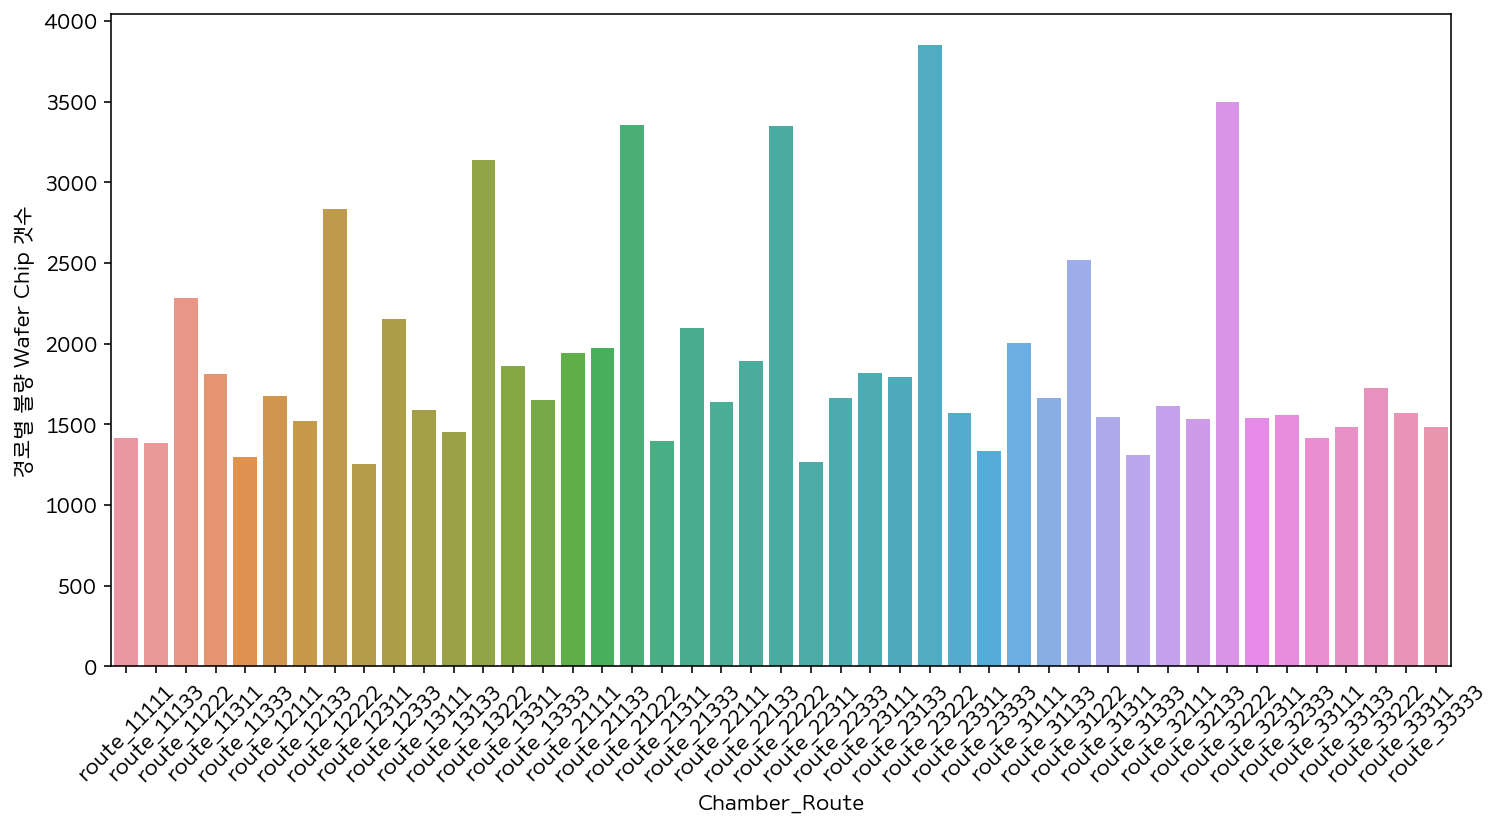

In [57]:
plt.figure(figsize=(12,6))
sns.barplot(data=Chamber_Route_error, x='Chamber_Route', y='Target')
plt.xticks(rotation=45)
plt.ylabel('경로별 불량 Wafer Chip 갯수')
plt.show()

### 공정 경로 별 Wafer 수 대비 내 불량비율(과부하) 계산

In [58]:
df3.head()

,Etching_Chamber,Process 3,Temp_Etching,Source_Power,Selectivity,No_Die,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1,ER,Chamber_Num,process4,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Temp_implantation,Furance_Temp,RTA_Temp,Target,Error_message,target_binom,lithography_Chamber,Line_CD,UV_type,Wavelength,Resolution,Energy_Exposure,Range_check,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,Reinforcement,photo_soft_Chamber,process 2,resist_target,N2_HMDS,pressure_HMDS,temp_HMDS,temp_HMDS_bake,time_HMDS_bake,spin1,spin2,spin3,photoresist_bake,temp_softbake,time_softbake,Chamber_Route
0,3,Etching,70.878,50.851,1.047,NOLSM111,251.0,267.06,303.82,361.38,3.679333,3,Implantation,9.997373e+15,1.346079e+17,3.468281e+17,3.002593e+17,6.000007e+17,31574.410,102.847,885.0,154,96,none,0.0,1,30.959,H,405,516.657,109.769,True,1,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,False,1,Photo,1.211940,13.891,15.025,20.000,198.792,90.001,504.589,4082.622,5184.620,5.044,90.894,30.009,route_11133
1,2,Etching,69.561,52.283,1.051,NOLSM212,317.0,332.74,369.31,426.11,3.637000,2,Implantation,9.705928e+15,1.389326e+17,3.838008e+17,3.017903e+17,6.000012e+17,31580.213,104.323,919.0,154,102,none,0.0,2,29.653,H,405,501.894,107.102,True,1,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,False,1,Photo,0.887720,14.722,15.059,19.995,198.747,89.998,492.196,3960.739,5065.197,5.058,92.334,29.997,route_11222
2,1,Etching,70.968,51.610,1.017,NOLSM313,411.0,424.21,460.65,517.80,3.560000,1,Implantation,1.761358e+16,8.782248e+16,6.014497e+17,2.994231e+17,6.000002e+17,32162.414,100.605,916.0,155,95,none,0.0,3,28.063,I,365,506.750,110.471,True,1,Oxidation,dry,1062.467808,O2,39.51,0.217,128.0,705.471,True,1,Photo,1.113156,19.205,14.964,19.997,202.139,90.000,499.886,3981.691,4873.417,5.151,91.868,30.005,route_11311
3,1,Etching,70.146,51.286,1.027,NOLSM414,256.0,272.28,308.56,365.93,3.664333,1,Implantation,1.148303e+16,9.776566e+16,6.646884e+16,2.991354e+17,6.000003e+17,32874.925,101.739,911.0,156,117,none,0.0,1,31.556,I,365,537.603,107.072,True,1,Oxidation,dry,1114.704773,O2,32.88,0.201,90.0,710.772,True,2,Photo,0.882195,16.368,14.944,19.998,199.649,90.001,505.249,3922.191,5131.972,5.069,91.881,29.997,route_12111
4,2,Etching,71.174,51.996,1.050,NOLSM515,419.0,434.98,471.65,528.85,3.661667,2,Implantation,9.769204e+15,1.222219e+17,2.496090e+17,3.005576e+17,6.000013e+17,30985.928,106.422,872.0,155,143,none,0.0,2,31.969,I,365,560.574,108.073,True,1,Oxidation,dry,989.411946,O2,38.11,0.204,98.0,716.975,True,2,Photo,0.834001,13.926,14.933,20.002,204.544,90.001,501.089,4124.099,5108.355,5.055,91.212,30.001,route_12222


In [59]:
Chamber_Route_Table = pd.merge(Chamber_Route_count, Chamber_Route_error, on='Chamber_Route')
Chamber_Route_Table['Error_Rate'] = Chamber_Route_Table['Target'] / (200 * Chamber_Route_Table['count'])
Chamber_Route_Table.sort_values(by='Error_Rate', ascending=False).head(10)

,Chamber_Route,count,Target,Error_Rate
39,route_32333,8,1561,0.975625
26,route_23133,11,1792,0.814545
11,route_13133,9,1452,0.806667
21,route_22133,12,1895,0.789583
7,route_12222,20,2835,0.708750
15,route_21111,14,1942,0.693571
9,route_12333,16,2152,0.672500
19,route_21333,16,2096,0.655000
17,route_21222,26,3358,0.645769
33,route_31311,12,1548,0.645000


### 공정 경로 별 Wafer 수 대비 내 불량비율 시각화

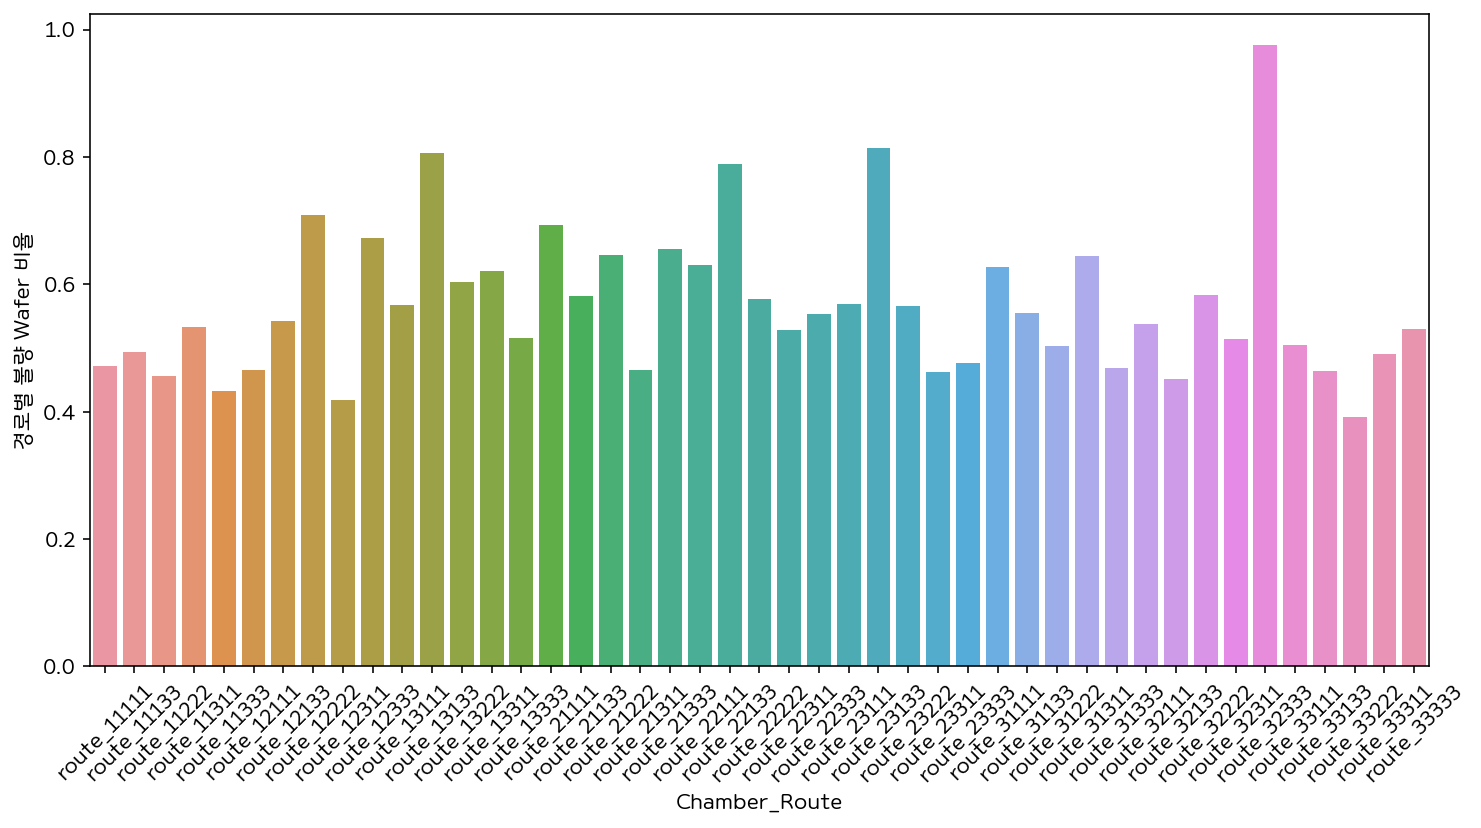

In [60]:
plt.figure(figsize=(12,6))
sns.barplot(data=Chamber_Route_Table, x='Chamber_Route', y='Error_Rate')
plt.xticks(rotation=45)
plt.ylabel('경로별 불량 Wafer 비율')
plt.show()

### 공정 경로 별 Wafer 수 대비 내 불량비율(과부하) 비율이 60%를 넘어가는 경로에 대해 과부하 여부 Column 생성

In [61]:
Chamber_Route_Table['과부하여부'] = np.where(Chamber_Route_Table['Error_Rate']>0.6, '비정상', '정상')
Chamber_Route_Table['과부하여부'].value_counts()

정상     31
비정상    14
Name: 과부하여부, dtype: int64

In [62]:
Chamber_Route_Table.head(3)

,Chamber_Route,count,Target,Error_Rate,과부하여부
0,route_11111,15,1415,0.471667,정상
1,route_11133,14,1382,0.493571,정상
2,route_11222,25,2281,0.456200,정상


### 전체 모든 공정 Wafer에 대해 과부하 Route와 정상 Route를 탄 Wafer의 빈도수 시각화
- 과부하 여부 데이터를 전체 데이터와 병합
- count plot을 이용한 데이터 시각화

In [63]:
df4 = pd.merge(df3, Chamber_Route_Table, on='Chamber_Route', how='left')
print(df4.shape)
df4.head()

(759, 61)


,Etching_Chamber,Process 3,Temp_Etching,Source_Power,Selectivity,No_Die,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1,ER,Chamber_Num,process4,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Temp_implantation,Furance_Temp,RTA_Temp,Target_x,Error_message,target_binom,lithography_Chamber,Line_CD,UV_type,Wavelength,Resolution,Energy_Exposure,Range_check,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,Reinforcement,photo_soft_Chamber,process 2,resist_target,N2_HMDS,pressure_HMDS,temp_HMDS,temp_HMDS_bake,time_HMDS_bake,spin1,spin2,spin3,photoresist_bake,temp_softbake,time_softbake,Chamber_Route,count,Target_y,Error_Rate,과부하여부
0,3,Etching,70.878,50.851,1.047,NOLSM111,251.0,267.06,303.82,361.38,3.679333,3,Implantation,9.997373e+15,1.346079e+17,3.468281e+17,3.002593e+17,6.000007e+17,31574.410,102.847,885.0,154,96,none,0.0,1,30.959,H,405,516.657,109.769,True,1,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,False,1,Photo,1.211940,13.891,15.025,20.000,198.792,90.001,504.589,4082.622,5184.620,5.044,90.894,30.009,route_11133,14,1382,0.493571,정상
1,2,Etching,69.561,52.283,1.051,NOLSM212,317.0,332.74,369.31,426.11,3.637000,2,Implantation,9.705928e+15,1.389326e+17,3.838008e+17,3.017903e+17,6.000012e+17,31580.213,104.323,919.0,154,102,none,0.0,2,29.653,H,405,501.894,107.102,True,1,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,False,1,Photo,0.887720,14.722,15.059,19.995,198.747,89.998,492.196,3960.739,5065.197,5.058,92.334,29.997,route_11222,25,2281,0.456200,정상
2,1,Etching,70.968,51.610,1.017,NOLSM313,411.0,424.21,460.65,517.80,3.560000,1,Implantation,1.761358e+16,8.782248e+16,6.014497e+17,2.994231e+17,6.000002e+17,32162.414,100.605,916.0,155,95,none,0.0,3,28.063,I,365,506.750,110.471,True,1,Oxidation,dry,1062.467808,O2,39.51,0.217,128.0,705.471,True,1,Photo,1.113156,19.205,14.964,19.997,202.139,90.000,499.886,3981.691,4873.417,5.151,91.868,30.005,route_11311,17,1811,0.532647,정상
3,1,Etching,70.146,51.286,1.027,NOLSM414,256.0,272.28,308.56,365.93,3.664333,1,Implantation,1.148303e+16,9.776566e+16,6.646884e+16,2.991354e+17,6.000003e+17,32874.925,101.739,911.0,156,117,none,0.0,1,31.556,I,365,537.603,107.072,True,1,Oxidation,dry,1114.704773,O2,32.88,0.201,90.0,710.772,True,2,Photo,0.882195,16.368,14.944,19.998,199.649,90.001,505.249,3922.191,5131.972,5.069,91.881,29.997,route_12111,18,1677,0.465833,정상
4,2,Etching,71.174,51.996,1.050,NOLSM515,419.0,434.98,471.65,528.85,3.661667,2,Implantation,9.769204e+15,1.222219e+17,2.496090e+17,3.005576e+17,6.000013e+17,30985.928,106.422,872.0,155,143,none,0.0,2,31.969,I,365,560.574,108.073,True,1,Oxidation,dry,989.411946,O2,38.11,0.204,98.0,716.975,True,2,Photo,0.834001,13.926,14.933,20.002,204.544,90.001,501.089,4124.099,5108.355,5.055,91.212,30.001,route_12222,20,2835,0.708750,비정상


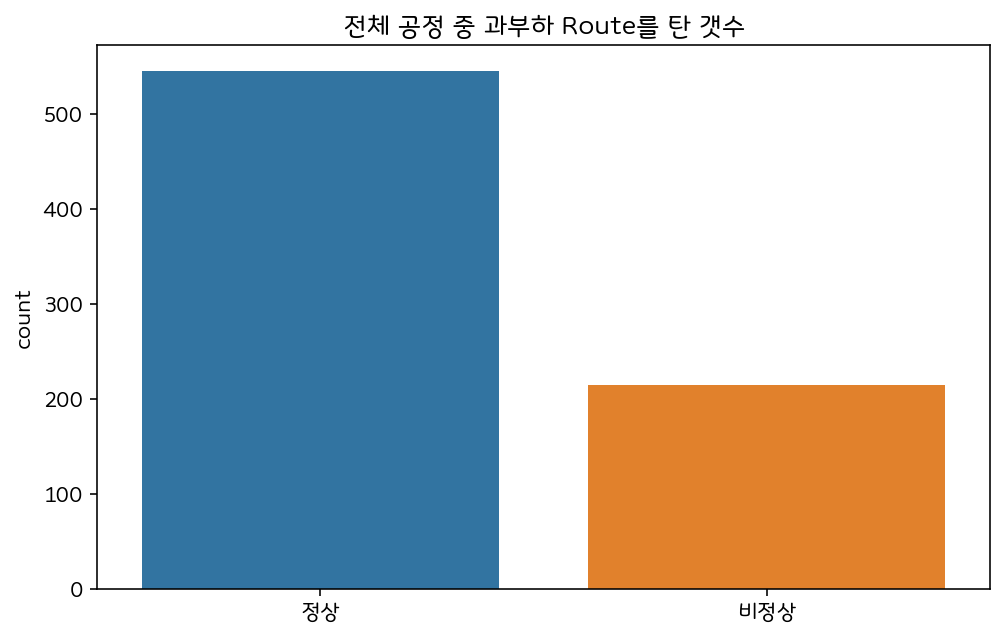

In [64]:
temp = df4['과부하여부'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=list(temp.index) ,y=temp.values)
plt.title('전체 공정 중 과부하 Route를 탄 갯수')
plt.ylabel('count')
plt.show()

### 공정 주요 인자들에 대한 부하여부에 따른 분포 확인

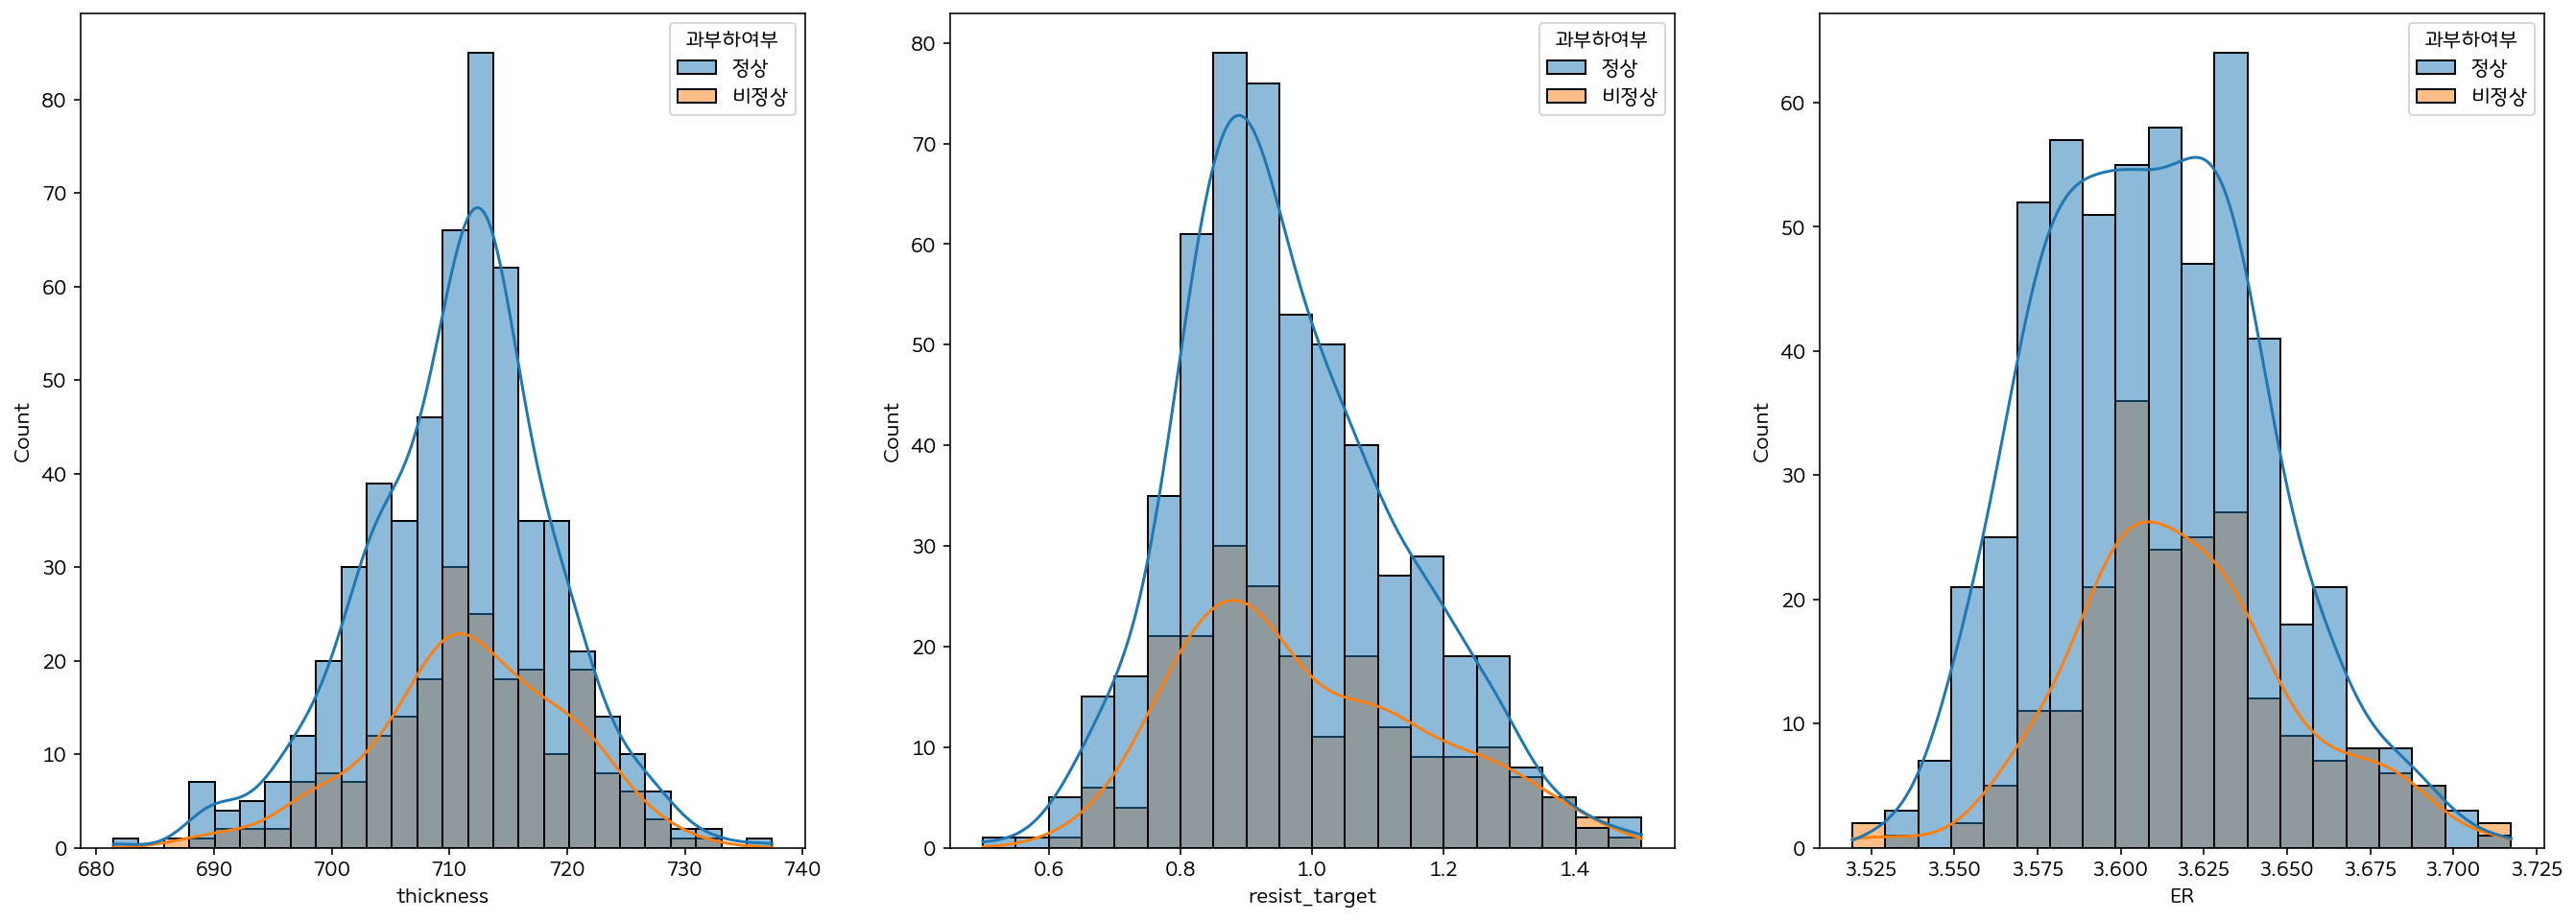

In [65]:
plt.figure(figsize=(23,8))
plt.subplot(1,3,1)
sns.histplot(x= df4['thickness'], hue=df4['과부하여부'], kde=True)
plt.subplot(1,3,2)
sns.histplot(x= df4['resist_target'], hue=df4['과부하여부'], kde=True)
plt.subplot(1,3,3)
sns.histplot(x= df4['ER'], hue=df4['과부하여부'], kde=True)
plt.show()

In [66]:
# run all cell break
a = 'strasdf123123'
print(int(a))

ValueError: invalid literal for int() with base 10: 'strasdf123123'

### 모든 공정 인자들에 대한 부하여부에 따른 분포 확인

In [ ]:
df_all_numeric = df4[['ppm', 'Pressure', 'Oxid_time', 'thickness', 'resist_target', 'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake',
                      'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake', 'temp_softbake', 'time_softbake', 'Line_CD', 'Resolution', 
                      'Energy_Exposure', 'Temp_Etching', 'Source_Power', 'Selectivity', 'ER', 'Flux60s', 'Flux90s', 'Flux160s', 'Flux480s', 'Flux840s',
                      'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp', 'Target_x', 'Error_Rate', '과부하여부']]

In [ ]:
sns.pairplot(data=df_all_numeric, hue='과부하여부')

### 각 Chamber Route 별 불량 개수의 유의미한 차이가 있는지 검정

In [ ]:
# temp = df4[['Chamber_Route', 'Target_y', 'count']]
# temp = temp.pivot_table(index='Chamber_Route', values=['Target_y', 'count'])
# temp.rename('Target_y':)

In [ ]:
# df4.columns

# 6. Modeling

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

In [ ]:
# Y = df1['target_binom']
# X = df1.drop(columns=['Ox_Chamber', 'process', 'type', 'Vapor', 'No_Die', 'Reinforcement', 'photo_soft_Chamber',
#                                'process 2', 'lithography_Chamber', 'UV_type', 'Range_check', 'Etching_Chamber', 'Process 3',
#                                'Chamber_Num', 'process4', 'Error_message', 'target_binom', 'Target', 'Datetime_x', 'Datetime_y', 'Lamp', 'Wafer_map'])

In [ ]:
Y = df4['target_binom']
a = list(df4.columns)
b = ['Ox_Chamber', 'process', 'type', 'Vapor', 'No_Die', 'Reinforcement', 'photo_soft_Chamber',
                               'process 2', 'lithography_Chamber', 'UV_type', 'Range_check', 'Etching_Chamber', 'Process 3',
                               'Chamber_Num', 'process4', 'Error_message', 'target_binom', '과부하여부', 'Chamber_Route']
X = df4.drop(columns=b)
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# X_train

In [ ]:
from tqdm import tqdm

In [ ]:
clf_grid = GridSearchCV(DecisionTreeClassifier(), n_jobs=-1,
            param_grid={'class_weight': [None, 'balanced'],
                            'criterion':['gini', 'entropy'],
                            'max_depth': [2,3,4,5,6,7],
                            'min_samples_leaf': [3,4,5,6,7],
                            'min_samples_split': [4,5,6,7,8]},
            scoring='f1')
clf_grid.fit(X_train, y_train)
print(clf_grid.score(X_train, y_train))
print('Best Parameter : ', clf_grid.best_params_)
print('Best Estimators : ', clf_grid.best_estimator_)
# clf_grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=params, n_jobs=-1)
# clf_grid.fit(train1, label1)
# print(clf_grid.score(train1, label1))
# # best hyperparameter를 찾아준다.
# print('Best Parameter : ', clf_grid.best_params_)
# print('Best Estimators : ', clf_grid.best_estimator_)

In [ ]:
a=1